In [40]:
from scipy.io import loadmat
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pickle
from behavioral_models.motor_adaptation_one_rate import motor_adaptation_one_rate
from behavioral_models.motor_adaptation_two_rate import motor_adaptation_two_rate

In [25]:
def build_motor_adaptation_one_rate_model(subject_id, Y, P, V, A, B, var_eta, var_epsilon, num_trials):
    tsm = motor_adaptation_one_rate(name=f"S{subject_id}", perturbation=P, vision=V, A=A, B=B, var_eta=var_eta, var_epsilon=var_epsilon, num_trials=num_trials)
    tsm.build_statespace_graph(data=Y)

def build_motor_adaptation_two_rate_model(subject_id, Y, P, V, Af, As, Bf, Bs, var_etaf, var_etas, var_epsilon, num_trials):
    tsm = motor_adaptation_two_rate(name=f"S{subject_id}", perturbation=P, vision=V, Af=Af, As=As, Bf=Bf, Bs=Bs, var_etaf=var_etaf, var_etas=var_etas, var_epsilon=var_epsilon, num_trials=num_trials)
    tsm.build_statespace_graph(data=Y)

def run_motor_adaptation_model(Y, V, P, two_rate, hierarchical, **kwargs):
    num_subjects = Y.shape[0]
    num_trials = Y.shape[1]+1
    
    Y = np.concatenate((np.zeros((num_subjects,1)), Y), axis=1)
    V = np.concatenate((V, np.zeros((num_subjects,1))), axis=1)
    P = np.concatenate((P, np.ones((num_subjects,1))), axis=1)
    
    coords = {'state': ['x', 'y'],
    'state_aux': ['x', 'y'],
    'observed_state': ['y_est'],
    'observed_state_aux': ['y_est'],
    'shock': ['var_eta', 'var_epsilon'],
    'shock_aux': ['var_eta', 'var_epsilon'],
    'subjects': np.arange(num_subjects)}
    
    priors = kwargs.get('priors', None)

    with pm.Model(coords=coords) as mod:
        if two_rate:
            if priors is None:
                priors = {'imAf_logit_mu_mu':0,'imAf_logit_mu_sd':1,
                'imAf_logit_sd_mu':2,'imAf_logit_sd_sd':1,
                'imAs_logit_mu_mu':0,'imAs_logit_mu_sd':1,
                'imAs_logit_sd_mu':2,'imAs_logit_sd_sd':1,
                'Bf_logit_mu_mu':0,'Bf_logit_mu_sd':1,
                'Bf_logit_sd_mu':2,'Bf_logit_sd_sd':1,
                'Bs1_logit_mu_mu':0,'Bs1_logit_mu_sd':1,
                'Bs1_logit_sd_mu':2,'Bs1_logit_sd_sd':1,
                'var_total_mu_mu':2,'var_total_mu_sd':1,
                'var_total_sd_mu':2,'var_total_sd_sd':1,
                'ratio_logit_mu_mu':0,'ratio_logit_mu_sd':1,
                'ratio_logit_sd_mu':2,'ratio_logit_sd_sd':1,
                'ratio2_logit_mu_mu':0,'ratio2_logit_mu_sd':1,
                'ratio2_logit_sd_mu':2,'ratio2_logit_sd_sd':1
                }
            if hierarchical:
                # Shared hyperparameters
                imAf_logit_mu = pm.Normal("imAf_logit_mu", mu=priors['imAf_logit_mu_mu'], sigma=priors['imAf_logit_mu_sd'])
                imAf_logit_sd = pm.Gamma("imAf_logit_sd", mu=priors['imAf_logit_sd_mu'], sigma=priors['imAf_logit_sd_sd'])
                imAs_logit_mu = pm.Normal("imAs_logit_mu", mu=priors['imAs_logit_mu_mu'], sigma=priors['imAs_logit_mu_sd'])
                imAs_logit_sd = pm.Gamma("imAs_logit_sd", mu=priors['imAs_logit_sd_mu'], sigma=priors['imAs_logit_sd_sd'])
                Bf_logit_mu = pm.Normal("Bf_logit_mu", mu=priors['Bf_logit_mu_mu'], sigma=priors['Bf_logit_mu_sd'])
                Bf_logit_sd = pm.Gamma("Bf_logit_sd", mu=priors['Bf_logit_sd_mu'], sigma=priors['Bf_logit_sd_sd'])
                Bs1_logit_mu = pm.Normal("Bs1_logit_mu", mu=priors['Bs1_logit_mu_mu'], sigma=priors['Bs1_logit_mu_sd'])
                Bs1_logit_sd = pm.Gamma("Bs1_logit_sd", mu=priors['Bs1_logit_sd_mu'], sigma=priors['Bs1_logit_sd_sd'])
                var_total_mu = pm.Gamma("var_total_mu", mu=priors['var_total_mu_mu'], sigma=priors['var_total_mu_sd'])
                var_total_sd = pm.Gamma("var_total_sd", mu=priors['var_total_sd_mu'], sigma=priors['var_total_sd_sd'])
                ratio_logit_mu = pm.Normal("ratio_logit_mu", mu=priors['ratio_logit_mu_mu'], sigma=priors['ratio_logit_mu_sd'])
                ratio_logit_sd = pm.Gamma("ratio_logit_sd", mu=priors['ratio_logit_sd_mu'], sigma=priors['ratio_logit_sd_sd'])
                ratio2_logit_mu = pm.Normal("ratio2_logit_mu", mu=priors['ratio2_logit_mu_mu'], sigma=priors['ratio2_logit_mu_sd'])
                ratio2_logit_sd = pm.Gamma("ratio2_logit_sd", mu=priors['ratio2_logit_sd_mu'], sigma=priors['ratio2_logit_sd_sd'])

                # Subject-level parameters (with dims)
                imAf_logit = pm.Normal("imAf_logit", mu=imAf_logit_mu, sigma=imAf_logit_sd, dims=["subjects"])  
                imAf = pm.Deterministic("imAf", pm.math.sigmoid(imAf_logit), dims=["subjects"]) # Centered around sigmoid(-0.4) ≈ 0.4 = imA
                Af = pm.Deterministic("Af", 1.0 - imAf, dims=["subjects"])                      # Af = 0.6
                imAs_logit = pm.Normal("imAs_logit", mu=imAs_logit_mu, sigma=imAs_logit_sd, dims=["subjects"])
                imAs = pm.Deterministic("imAs", pm.math.sigmoid(imAs_logit), dims=["subjects"]) # Centered around sigmoid(0) ≈ 0.5 = imAs
                As = pm.Deterministic("As", 1.0 - imAf * imAs, dims=["subjects"])  #  As > Af
                Bf_logit = pm.Normal("Bf_logit", mu=Bf_logit_mu, sigma=Bf_logit_sd, dims=["subjects"])  # -2 < Bf_logit < -1
                Bf = pm.Deterministic("Bf", pm.math.sigmoid(Bf_logit), dims=["subjects"]) # 0.12 < Bf < 0.27   
                Bs1_logit = pm.Normal("Bs1_logit", mu=Bs1_logit_mu, sigma=Bs1_logit_sd, dims=["subjects"])  # -2 < Bs1_logit < 0
                Bs_logit = pm.Deterministic("Bs_logit", Bf_logit + Bs1_logit, dims=["subjects"])                  # Bs_logit < Bf_logit
                Bs = pm.Deterministic("Bs", pm.math.sigmoid(Bs_logit), dims=["subjects"]) # Bs < Bf
                var_total = pm.Gamma("var_total", mu=var_total_mu, sigma=var_total_sd, dims=["subjects"])
                ratio_logit = pm.Normal("ratio_logit", mu=ratio_logit_mu, sigma=ratio_logit_sd, dims=["subjects"])  
                ratio = pm.Deterministic("ratio", pm.math.sigmoid(ratio_logit), dims=["subjects"])
                ratio2_logit = pm.Normal("ratio2_logit", mu=ratio2_logit_mu, sigma=ratio2_logit_sd, dims=["subjects"])  
                ratio2 = pm.Deterministic("ratio2", pm.math.sigmoid(ratio2_logit), dims=["subjects"])
                var_etaf = pm.Deterministic("var_etaf", var_total * ratio * ratio2, dims=["subjects"])
                sigma_etaf = pm.Deterministic("sigma_etaf", pm.math.sqrt(var_etaf), dims=["subjects"])
                var_etas = pm.Deterministic("var_etas", var_total * ratio * (1-ratio2), dims=["subjects"])
                sigma_etas = pm.Deterministic("sigma_etas", pm.math.sqrt(var_etas), dims=["subjects"])
                var_epsilon = pm.Deterministic("var_epsilon", var_total * (1 - ratio), dims=["subjects"])
                sigma_epsilon = pm.Deterministic("sigma_epsilon", pm.math.sqrt(var_epsilon), dims=["subjects"])
            else:
                # Subject-level parameters (with dims)
                imAf_logit = pm.Normal("imAf_logit", mu=priors['imAf_logit_mu_mu'], sigma=priors['imAf_logit_sd_mu'], dims=["subjects"])  
                imAf = pm.Deterministic("imAf", pm.math.sigmoid(imAf_logit), dims=["subjects"]) # Centered around sigmoid(-0.4) ≈ 0.4 = imA
                Af = pm.Deterministic("Af", 1.0 - imAf, dims=["subjects"])                      # Af = 0.6
                imAs_logit = pm.Normal("imAs_logit", mu=priors['imAs_logit_mu_mu'], sigma=priors['imAs_logit_sd_mu'], dims=["subjects"])
                imAs = pm.Deterministic("imAs", pm.math.sigmoid(imAs_logit), dims=["subjects"]) # Centered around sigmoid(0) ≈ 0.5 = imAs
                As = pm.Deterministic("As", 1.0 - imAf * imAs, dims=["subjects"])  #  As > Af
                Bf_logit = pm.Normal("Bf_logit", mu=priors['Bf_logit_mu_mu'], sigma=priors['Bf_logit_sd_mu'], dims=["subjects"])  # -2 < Bf_logit < -1
                Bf = pm.Deterministic("Bf", pm.math.sigmoid(Bf_logit), dims=["subjects"]) # 0.12 < Bf < 0.27   
                Bs1_logit = pm.Normal("Bs1_logit", mu=priors['Bs1_logit_mu_mu'], sigma=priors['Bs1_logit_sd_mu'], dims=["subjects"])  # -2 < Bs1_logit < 0
                Bs_logit = pm.Deterministic("Bs_logit", Bf_logit + Bs1_logit, dims=["subjects"])                  # Bs_logit < Bf_logit
                Bs = pm.Deterministic("Bs", pm.math.sigmoid(Bs_logit), dims=["subjects"]) # Bs < Bf
                var_total = pm.Gamma("var_total", mu=priors['var_total_mu_mu'], sigma=priors['var_total_sd_mu'], dims=["subjects"])
                ratio_logit = pm.Normal("ratio_logit", mu=priors['ratio_logit_mu_mu'], sigma=priors['ratio_logit_sd_mu'], dims=["subjects"])  
                ratio = pm.Deterministic("ratio", pm.math.sigmoid(ratio_logit), dims=["subjects"])
                ratio2_logit = pm.Normal("ratio2_logit", mu=priors['ratio2_logit_mu_mu'], sigma=priors['ratio2_logit_sd_mu'], dims=["subjects"])  
                ratio2 = pm.Deterministic("ratio2", pm.math.sigmoid(ratio2_logit), dims=["subjects"])
                var_etaf = pm.Deterministic("var_etaf", var_total * ratio * ratio2, dims=["subjects"])
                sigma_etaf = pm.Deterministic("sigma_etaf", pm.math.sqrt(var_etaf), dims=["subjects"])
                var_etas = pm.Deterministic("var_etas", var_total * ratio * (1-ratio2), dims=["subjects"])
                sigma_etas = pm.Deterministic("sigma_etas", pm.math.sqrt(var_etas), dims=["subjects"])
                var_epsilon = pm.Deterministic("var_epsilon", var_total * (1 - ratio), dims=["subjects"])
                sigma_epsilon = pm.Deterministic("sigma_epsilon", pm.math.sqrt(var_epsilon), dims=["subjects"])

            # Use for loop instead of scan to avoid symbolic naming issues
            for i in range(num_subjects):
                # Create subject-specific variables with the correct prefix
                x0_i = pm.Data(f"S{i}_x0", np.zeros(3, dtype="float"))
                P0_i = pm.Data(f"S{i}_P0", np.eye(3))
                Af_i = pm.Deterministic(f"S{i}_Af", Af[i])
                As_i = pm.Deterministic(f"S{i}_As", As[i])
                Bf_i = pm.Deterministic(f"S{i}_Bf", Bf[i])
                Bs_i = pm.Deterministic(f"S{i}_Bs", Bs[i])
                var_etaf_i = pm.Deterministic(f"S{i}_var_etaf", var_etaf[i])
                var_etas_i = pm.Deterministic(f"S{i}_var_etas", var_etas[i])
                var_epsilon_i = pm.Deterministic(f"S{i}_var_epsilon", var_epsilon[i])
                
                build_motor_adaptation_two_rate_model(
                    subject_id=i,
                    Y=Y[i].reshape(-1, 1),  # Reshape to 2D: (n_timesteps, 1)
                    P=P[i],
                    V=V[i],
                    Af=Af_i,
                    As=As_i,
                    Bf=Bf_i,
                    Bs=Bs_i,
                    var_etaf=var_etaf_i,
                    var_etas=var_etas_i,
                    var_epsilon=var_epsilon_i,
                    num_trials=num_trials
                )
        else:
            if priors is None:
                priors = {'A_logit_mu_mu':0,'A_logit_mu_sd':1,
                'A_logit_sd_mu':2,'A_logit_sd_sd':1,
                'B_logit_mu_mu':0,'B_logit_mu_sd':1,
                'B_logit_sd_mu':2,'B_logit_sd_sd':1,
                'var_total_mu_mu':2,'var_total_mu_sd':1,
                'var_total_sd_mu':2,'var_total_sd_sd':1,
                'ratio_logit_mu_mu':0,'ratio_logit_mu_sd':1,
                'ratio_logit_sd_mu':2,'ratio_logit_sd_sd':1
                }
            if hierarchical:
                # Shared hyperparameters
                A_logit_mu = pm.Normal("A_logit_mu", mu=priors['A_logit_mu_mu'], sigma=priors['A_logit_mu_sd'])
                A_logit_sd = pm.Gamma("A_logit_sd", mu=priors['A_logit_sd_mu'], sigma=priors['A_logit_sd_sd'])
                B_logit_mu = pm.Normal("B_logit_mu", mu=priors['B_logit_mu_mu'], sigma=priors['B_logit_mu_sd'])
                B_logit_sd = pm.Gamma("B_logit_sd", mu=priors['B_logit_sd_mu'], sigma=priors['B_logit_sd_sd'])
                var_total_mu = pm.Gamma("var_total_mu", mu=priors['var_total_mu_mu'], sigma=priors['var_total_mu_sd'])
                var_total_sd = pm.Gamma("var_total_sd", mu=priors['var_total_sd_mu'], sigma=priors['var_total_sd_sd'])
                ratio_logit_mu = pm.Normal("ratio_logit_mu", mu=priors['ratio_logit_mu_mu'], sigma=priors['ratio_logit_mu_sd'])
                ratio_logit_sd = pm.Gamma("ratio_logit_sd", mu=priors['ratio_logit_sd_mu'], sigma=priors['ratio_logit_sd_sd'])

                # Subject-level parameters (with dims)
                A_logit = pm.Normal("A_logit", mu=A_logit_mu, sigma=A_logit_sd, dims=["subjects"])  
                A = pm.Deterministic("A", pm.math.sigmoid(A_logit), dims=["subjects"])
                B_logit = pm.Normal("B_logit", mu=B_logit_mu, sigma=B_logit_sd, dims=["subjects"])
                B = pm.Deterministic("B", pm.math.sigmoid(B_logit), dims=["subjects"])
                var_total = pm.Gamma("var_total", mu=var_total_mu, sigma=var_total_sd, dims=["subjects"])
                ratio_logit = pm.Normal("ratio_logit", mu=ratio_logit_mu, sigma=ratio_logit_sd, dims=["subjects"])  
                ratio = pm.Deterministic("ratio", pm.math.sigmoid(ratio_logit), dims=["subjects"])
                var_eta = pm.Deterministic("var_eta", var_total * ratio, dims=["subjects"])
                sigma_eta = pm.Deterministic("sigma_eta", pm.math.sqrt(var_eta), dims=["subjects"])
                var_epsilon = pm.Deterministic("var_epsilon", var_total * (1 - ratio), dims=["subjects"])
                sigma_epsilon = pm.Deterministic("sigma_epsilon", pm.math.sqrt(var_epsilon), dims=["subjects"])
            else:
                # Subject-level parameters (with dims)
                A_logit = pm.Normal("A_logit", mu=priors['A_logit_mu_mu'], sigma=priors['A_logit_sd_mu'], dims=["subjects"])  
                A = pm.Deterministic("A", pm.math.sigmoid(A_logit), dims=["subjects"])
                B_logit = pm.Normal("B_logit", mu=priors['B_logit_mu_mu'], sigma=priors['B_logit_sd_mu'], dims=["subjects"])
                B = pm.Deterministic("B", pm.math.sigmoid(B_logit), dims=["subjects"])
                var_total = pm.Gamma("var_total", mu=priors['var_total_mu_mu'], sigma=priors['var_total_sd_mu'], dims=["subjects"])
                ratio_logit = pm.Normal("ratio_logit", mu=priors['ratio_logit_mu_mu'], sigma=priors['ratio_logit_sd_mu'], dims=["subjects"])  
                ratio = pm.Deterministic("ratio", pm.math.sigmoid(ratio_logit), dims=["subjects"])
                var_eta = pm.Deterministic("var_eta", var_total * ratio, dims=["subjects"])
                sigma_eta = pm.Deterministic("sigma_eta", pm.math.sqrt(var_eta), dims=["subjects"])
                var_epsilon = pm.Deterministic("var_epsilon", var_total * (1 - ratio), dims=["subjects"])
                sigma_epsilon = pm.Deterministic("sigma_epsilon", pm.math.sqrt(var_epsilon), dims=["subjects"])

            # Use for loop instead of scan to avoid symbolic naming issues
            for i in range(num_subjects):
                # Create subject-specific variables with the correct prefix
                x0_i = pm.Data(f"S{i}_x0", np.zeros(2, dtype="float"))
                P0_i = pm.Data(f"S{i}_P0", np.eye(2))
                A_i = pm.Deterministic(f"S{i}_A", A[i])
                B_i = pm.Deterministic(f"S{i}_B", B[i])
                var_eta_i = pm.Deterministic(f"S{i}_var_eta", var_eta[i])
                var_epsilon_i = pm.Deterministic(f"S{i}_var_epsilon", var_epsilon[i])

                build_motor_adaptation_one_rate_model(
                    subject_id=i,
                    Y=Y[i].reshape(-1, 1),  # Reshape to 2D: (n_timesteps, 1)
                    P=P[i],
                    V=V[i],
                    A=A_i,
                    B=B_i,
                    var_eta=var_eta_i,
                    var_epsilon=var_epsilon_i,
                    num_trials=num_trials
                )
    #idata = pm.sample(1000, tune=1000, target_accept=0.95, model=mod, nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}, progressbar=False)
    idata = pm.sample(1000, tune=1000, target_accept=0.95, model=mod, nuts_sampler="numpyro")
    return idata,mod

In [29]:
def generate_data(perturbation, vision, priors):
    num_subjects = perturbation.shape[0]
    num_trials = perturbation.shape[1]
    
    if priors["rate"]==1:
        # Model parameters
        A_gen = np.random.normal(priors["A_logit_mu_mu"],priors["A_logit_sd_mu"],num_subjects)
        A_gen = 1/(1+(np.exp((-A_gen))))
        B_gen = np.random.normal(priors["B_logit_mu_mu"],priors["B_logit_sd_mu"],num_subjects)
        B_gen = 1/(1+(np.exp((-B_gen))))
        var_total_mu = priors["var_total_mu_mu"]
        var_total_var = np.pow(priors["var_total_sd_mu"],2)
        scale = var_total_var/var_total_mu
        shape = var_total_mu/scale
        var_total = np.random.gamma(shape, scale, num_subjects)
        ratio = np.random.normal(priors["ratio_logit_mu_mu"],priors["ratio_logit_sd_mu"],num_subjects)
        ratio = 1/(1+(np.exp((-ratio))))
        sigma_eta_gen = np.sqrt(var_total * ratio)
        sigma_epsilon_gen = np.sqrt(var_total * (1-ratio))
        
        # initialize
        x = np.zeros((num_subjects, num_trials+1))
        y_obs = np.zeros((num_subjects, num_trials))
        eta_gen = np.random.normal(0, sigma_eta_gen.reshape(-1,1), [num_subjects, num_trials+1])
        epsilon_gen = np.random.normal(0, sigma_epsilon_gen.reshape(-1,1), [num_subjects,num_trials])
        gen_params = {'A_gen': A_gen, 'B_gen': B_gen, 'sigma_eta_gen': sigma_eta_gen, 'sigma_epsilon_gen': sigma_epsilon_gen}

        # step 0
        x[0,:] = eta_gen[0,:]

        # update
        for s in range(num_subjects):
            for t in range(num_trials):
                y_obs[s,t] = x[s,t] + perturbation[s,t] + epsilon_gen[s,t]
                x[s,t+1] = A_gen[s] * x[s,t] - vision[s,t] * B_gen[s] * y_obs[s,t] + eta_gen[s,t+1]
                
    elif priors["rate"]==2:
        # Model parameters
        imAf_logit = np.random.normal(priors["imAf_logit_mu_mu"], priors["imAf_logit_sd_mu"], num_subjects)  
        imAf = 1/(1+(np.exp((-imAf_logit))))
        Af_gen = 1-imAf
        imAs_logit = np.random.normal(priors["imAs_logit_mu_mu"], priors["imAs_logit_sd_mu"], num_subjects)
        imAs = 1/(1+(np.exp((-imAs_logit))))
        As_gen = 1 - imAf * imAs
        Bf_logit = np.random.normal(priors["Bf_logit_mu_mu"], priors["Bf_logit_mu_mu"], num_subjects)
        Bf_gen = 1/(1+(np.exp((-Bf_logit))))
        Bs1_logit = np.random.normal(priors["Bs1_logit_mu_mu"], priors["Bs1_logit_sd_mu"], num_subjects)
        Bs_gen = 1/(1+(np.exp((-Bf_logit+Bs1_logit))))
        var_total_mu = priors["var_total_mu_mu"]
        var_total_var = np.pow(priors["var_total_sd_mu"],2)
        scale = var_total_var/var_total_mu
        shape = var_total_mu/scale
        var_total = np.random.gamma(shape, scale, num_subjects)
        ratio = np.random.normal(priors["ratio_logit_mu_mu"],priors["ratio_logit_sd_mu"],num_subjects)
        ratio = 1/(1+(np.exp((-ratio))))
        ratio2 = np.random.normal(priors["ratio2_logit_mu_mu"],priors["ratio2_logit_sd_mu"],num_subjects)
        ratio2 = 1/(1+(np.exp((-ratio2))))
        sigma_etaf_gen = np.sqrt(var_total * ratio * ratio2)
        sigma_etas_gen = np.sqrt(var_total * ratio * (1-ratio2))
        sigma_epsilon_gen = np.sqrt(var_total * (1-ratio))
        
        # initialize
        xf = np.zeros((num_subjects, num_trials+1))
        xs = np.zeros((num_subjects, num_trials+1))
        y_obs = np.zeros((num_subjects, num_trials))
        etaf_gen = np.random.normal(0, sigma_etaf_gen.reshape(-1,1), [num_subjects, num_trials+1])
        etas_gen = np.random.normal(0, sigma_etas_gen.reshape(-1,1), [num_subjects, num_trials+1])
        epsilon_gen = np.random.normal(0, sigma_epsilon_gen.reshape(-1,1), [num_subjects,num_trials])
        gen_params = {'Af_gen': Af_gen, 'As_gen': As_gen, 'Bf_gen': Bf_gen, 'Bs_gen': Bs_gen,
                           'sigma_etaf_gen': sigma_etaf_gen, 'sigma_etas_gen': sigma_etas_gen, 'sigma_epsilon_gen': sigma_epsilon_gen}

        # step 0
        xf[0,:] = etaf_gen[0,:]
        xs[0,:] = etaf_gen[0,:]

        # update
        for s in range(num_subjects):
            for t in range(num_trials):
                y_obs[s,t] = xf[s,t] + xs[s,t] + perturbation[s,t] + epsilon_gen[s,t]
                xf[s,t+1] = Af_gen[s] * xf[s,t] - vision[s,t] * Bf_gen[s] * y_obs[s,t] + etaf_gen[s,t+1]
                xs[s,t+1] = As_gen[s] * xs[s,t] - vision[s,t] * Bs_gen[s] * y_obs[s,t] + etas_gen[s,t+1]
                    
    return y_obs,gen_params

In [ ]:
# Load data from Jonker - Neuroimage - 2021
data_mat = loadmat('behavioral_data/dataForBayesianAnalysisEEG-VM.mat', simplify_cells=True)
aimingError = np.transpose(data_mat['aimingError'])
rotation = np.transpose(data_mat['rotation'])
showcursor = np.transpose(data_mat['showCursor'])

Y = aimingError + rotation
V = showcursor
P = rotation

# Run one rate hierarchical model
idata,mod = run_motor_adaptation_model(Y, V, P, hierarchical=True)
idata.to_netcdf('output/jonker-neuroimage-2021/motor-adaptation-one-rate.nc')
with open('output/jonker-neuroimage-2021/motor-adaptation-one-rate.pickle', 'wb') as handle:
    pickle.dump(mod, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Run two rate hierarchical model
idata,mod = run_motor_adaptation_model(Y, V, P, hierarchical=True)
idata.to_netcdf('output/jonker-neuroimage-2021/motor-adaptation-two-rate.nc')
with open('output/jonker-neuroimage-2021/motor-adaptation-two-rate.pickle', 'wb') as handle:
    pickle.dump(mod, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
param_file = 'output/jonker-neuroimage-2021/motor-adaptation-one-rate.nc'
p_o_r = az.from_netcdf(param_file)
p_o_r = p_o_r.posterior
p_o_r = {'rate':1,
         'A_logit_mu_mu': p_o_r.A_logit_mu.mean().to_numpy(),'A_logit_mu_sd':p_o_r.A_logit_mu.std().to_numpy(),
         'A_logit_sd_mu':p_o_r.A_logit_sd.mean().to_numpy(),'A_logit_sd_sd':p_o_r.A_logit_sd.std().to_numpy(),
         'B_logit_mu_mu':p_o_r.B_logit_mu.mean().to_numpy(),'B_logit_mu_sd':p_o_r.B_logit_mu.std().to_numpy(),
         'B_logit_sd_mu':p_o_r.B_logit_sd.mean().to_numpy(),'B_logit_sd_sd':p_o_r.B_logit_sd.std().to_numpy(),
         'var_total_mu_mu':p_o_r.var_total_mu.mean().to_numpy(),'var_total_mu_sd':p_o_r.var_total_mu.std().to_numpy(),
         'var_total_sd_mu':p_o_r.var_total_sd.mean().to_numpy(),'var_total_sd_sd':p_o_r.var_total_sd.std().to_numpy(),
         'ratio_logit_mu_mu':p_o_r.ratio_logit_mu.mean().to_numpy(),'ratio_logit_mu_sd':p_o_r.ratio_logit_mu.std().to_numpy(),
         'ratio_logit_sd_mu':p_o_r.ratio_logit_sd.mean().to_numpy(),'ratio_logit_sd_sd':p_o_r.ratio_logit_sd.std().to_numpy()
        }

In [ ]:
param_file = 'output/jonker-neuroimage-2021/motor-adaptation-two-rate.nc'
p_t_r = az.from_netcdf(param_file)
p_t_r = p_t_r.posterior
p_t_r = {'rate':2,
         'imAf_logit_mu_mu':p_t_r.imAf_logit_mu.mean().to_numpy(),'imAf_logit_mu_sd':p_t_r.imAf_logit_mu.std().to_numpy(),
         'imAf_logit_sd_mu':p_t_r.imAf_logit_sd.mean().to_numpy(),'imAf_logit_sd_sd':p_t_r.imAf_logit_sd.std().to_numpy(),
         'imAs_logit_mu_mu':p_t_r.imAs_logit_mu.mean().to_numpy(),'imAs_logit_mu_sd':p_t_r.imAs_logit_mu.std().to_numpy(),
         'imAs_logit_sd_mu':p_t_r.imAs_logit_sd.mean().to_numpy(),'imAs_logit_sd_sd':p_t_r.imAs_logit_sd.std().to_numpy(),
         'Bf_logit_mu_mu':p_t_r.Bf_logit_mu.mean().to_numpy(),'Bf_logit_mu_sd':p_t_r.Bf_logit_mu.std().to_numpy(),
         'Bf_logit_sd_mu':p_t_r.Bf_logit_sd.mean().to_numpy(),'Bf_logit_sd_sd':p_t_r.Bf_logit_sd.std().to_numpy(),
         'Bs1_logit_mu_mu':p_t_r.Bs1_logit_mu.mean().to_numpy(),'Bs1_logit_mu_sd':p_t_r.Bs1_logit_mu.std().to_numpy(),
         'Bs1_logit_sd_mu':p_t_r.Bs1_logit_sd.mean().to_numpy(),'Bs1_logit_sd_sd':p_t_r.Bs1_logit_sd.std().to_numpy(),
         'var_total_mu_mu':p_t_r.var_total_mu.mean().to_numpy(),'var_total_mu_sd':p_t_r.var_total_mu.std().to_numpy(),
         'var_total_sd_mu':p_t_r.var_total_sd.mean().to_numpy(),'var_total_sd_sd':p_t_r.var_total_sd.std().to_numpy(),
         'ratio_logit_mu_mu':p_t_r.ratio_logit_mu.mean().to_numpy(),'ratio_logit_mu_sd':p_t_r.ratio_logit_mu.std().to_numpy(),
         'ratio_logit_sd_mu':p_t_r.ratio_logit_sd.mean().to_numpy(),'ratio_logit_sd_sd':p_t_r.ratio_logit_sd.std().to_numpy(),
         'ratio2_logit_mu_mu':p_t_r.ratio2_logit_mu.mean().to_numpy(),'ratio2_logit_mu_sd':p_t_r.ratio2_logit_mu.std().to_numpy(),
         'ratio2_logit_sd_mu':p_t_r.ratio2_logit_sd.mean().to_numpy(),'ratio2_logit_sd_sd':p_t_r.ratio2_logit_sd.std().to_numpy()
        }

In [32]:
# Generate data for the one and two rate adaptation models
num_trials = 110
num_subjects = 10
vision = np.ones((num_subjects, num_trials))
vision[:,5::10] = 0
perturbation = np.zeros((num_subjects, num_trials))  # initialize all to 0
perturbation[:,20:60] = 30
y_obs_one_rate,gen_params_one_rate = generate_data(perturbation, vision, p_o_r)
with open('output/simulations/gen_params.pickle', 'wb') as handle:
    pickle.dump(gen_params_one_rate, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
aap = {'noot':5}
pt.as_tensor_variable(aap['noot'])

a = p_o_r['A_logit_mu_mu'].to_numpy()
a

array(1.57423014)

In [57]:
# Estimate parameters with Bayesian or EM implementations of one and two rate models
idata,mod = run_motor_adaptation_model(y_obs_one_rate, vision, perturbation, two_rate=False, hierarchical=False, priors=p_o_r)
idata.to_netcdf('output/simulations/data-one-rate-model-one-rate-non-hierarchical.nc')
with open('output/simulations/data-one-rate-model-one-rate-non-hierarchical.pickle', 'wb') as handle:
    pickle.dump(mod, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/neuro_/Documents/GitHub/Bayesian-behavioral-toolbox/.pixi/envs/default/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:76: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/neuro_/Documents/GitHub/Bayesian-behavioral-toolbox/.pixi/envs/default/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:76: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/neuro_/Documents/GitHub/Bayesian-behavioral-toolbox/.pixi/envs/default/lib/python3.13/site-packages/pymc_extras/statespace/utils/data_tools.py:76: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/neuro_/Documents/GitHub/Bayesian-behavioral-toolbox/.pixi/envs/default/lib/python3.13/site-

KeyboardInterrupt: 

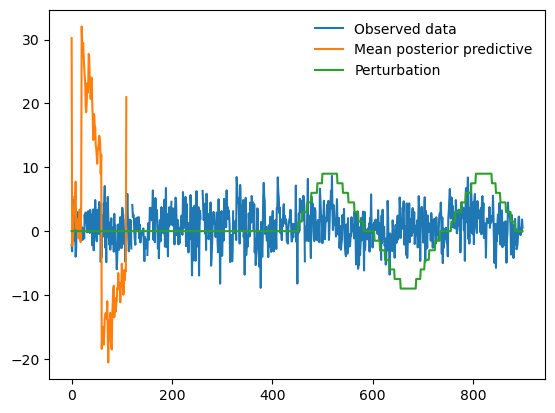

In [94]:
fig = plt.figure()
plt.plot(Y[0,:],label='Observed data')
time = idata.posterior_predictive['time']
Y_est = idata.posterior_predictive['S0_obs'].mean(['chain','draw']);
plt.plot(time[0:-1],Y_est[1:],label='Mean posterior predictive')
#plt.plot(np.append(P[0,:],0),label='Observed data')
#plt.plot(Y[0,0:],label='Observed data')
plt.plot(P[0,:],label='Perturbation')
plt.legend(frameon = False)
pp  =idata.posterior_predictive['time'],idata.posterior_predictive['S0_obs'].mean(['chain','draw'])
#pp[2][110]